# Модель хищник-жертва или  модель Лотки — Вольтерры

Простая модель описывающая сосуществование двух видов в изолированной среде.
Один вид - жертва, полностью обеспечен средой.
Второй вид - хищник питается исключительно жертвами.

В общем виде можно выразить через СОДУ:

$ {\frac {dx}{dt}}=(\alpha_1 -\beta_1 y)x $


$ {\frac {dy}{dt}}=(-\alpha_2 +\beta_2 x)y $

где $x$ - число жертв, $y$ - число хищников, $t$ - время, а $\alpha_1$, $\alpha_2$, $\beta_1$ и $\beta_2$ - параметры модели



In [23]:
from scipy.integrate import odeint
import pylab as plt
import numpy as np

def get_f(a1=1, a2=1, b1=1, b2=1):
    
    def f(xy, t):
        x, y = xy
        
        return np.array([(a1 - b1*y)*x, (-a2 + b2*x)*y])
    
    return f

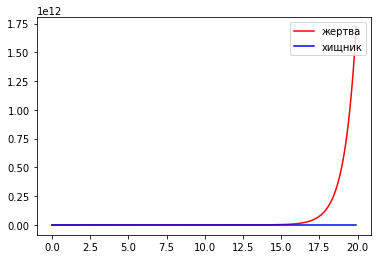

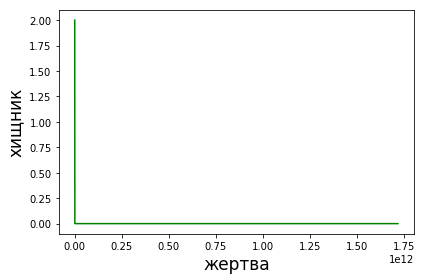

In [49]:
t = [0.1*i for i in range(200)]
xy0 = [10, 2]
    
dxy = odeint(get_f(a1=1.3,b1=0.5,a2=1,b2=0.05), xy0, t)

x = [i[0] for i in dxy]
y = [i[1] for i in dxy]

plt.plot(t, x, 'r')
plt.plot(t, y, 'b')
plt.legend(["жертва", "хищник"], loc=1)
plt.show()

plt.plot(x, y, 'g')
plt.xlabel('жертва', fontsize=17)
plt.ylabel('хищник', fontsize=17)
plt.tight_layout()
plt.show()

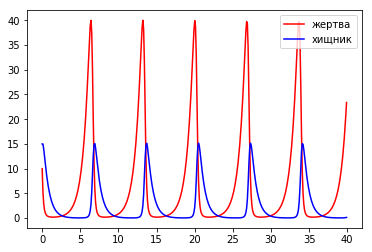

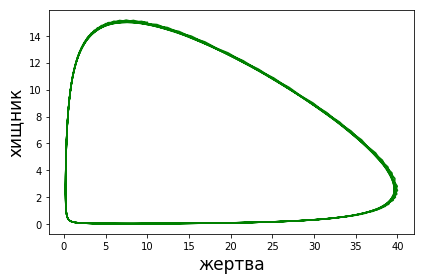

In [3]:
t = [0.1*i for i in range(400)]
xy0 = [10, 15]
    
dxy = odeint(get_f(a1=1.3,b1=0.5,a2=1.5,b2=0.2), xy0, t)

x = [i[0] for i in dxy]
y = [i[1] for i in dxy]

plt.plot(t, x, 'r')
plt.plot(t, y, 'b')
plt.legend(["жертва", "хищник"], loc=1)
plt.show()

plt.plot(x, y, 'g')
plt.xlabel('жертва', fontsize=17)
plt.ylabel('хищник', fontsize=17)
plt.tight_layout()
plt.show()

# Параметрическая идентификация на примере модели хищник-жертва

Рассмотрим такую задачу: 
нам не известны один или несколько параметров из СОДУ описывабщей систему, но есть некоторые "измерения" - набор значений $x_i$ и $y_i$ в некоторые моменты $t_i$.

Необходимо подобрать численные значения недостающих параметров модели.

Пусть нам неизвестны параметры $\alpha_1$ и $\alpha_2$ и необходимо их найти.

Для любого момента времени $t$ и зафиксированных значений параметров $\alpha_1$ и $\alpha_2$ мы можем вычислить значения $x$, $y$ и сравнить их с "эталонными" значениями. Наша задача состоит в том что бы минимизировать разницу.

Другими словами необходимо найти минимум функции заданной неявно(мы не имеем возможности вычислить производную), для этого существут несколько методов.

## Метод оптимизации Нелдера — Мида или симплекс-метод

Метод подробно описан в статье https://habr.com/ru/post/332092/.

Будем решаеть двумерную задачу, нам неизвестны параметры $\alpha_1$ и $\alpha_2$ и необходимо их найти.

Создадим эталонную систему и вычислим результаты "экспиремента".

In [54]:
t = [0.1*i for i in range(100)]
x0 = [10, 2]
    
x = odeint(get_f(a1=1.7,b1=0.5,a2=2.5,b2=0.2), x0, t)

Теперь необходимо задать функцию $F$, которую мы будем оптимизировать. Воспользуемся методом наименьших квадратов.

In [55]:
def F(a1, a2):
    lx = odeint(get_f(a1=a1, b1=0.5, a2=a2, b2=0.2), x0, t)
    
    f = 0
    
    for i in range(len(lx)):
        for j in range(len(lx[0])):
            f += (lx[i][j] - x[i][j]) ** 2
            
    return f

F(1.3, 1.5)

4479.3983065729917

Зная решение задачи выберем корректный симплекс.

In [57]:
v = [
    np.array([0, 0]),
    np.array([1, 5]),
    np.array([5, 1]),
]

In [58]:
iter_n = 0

mc = 1   # mirror coef
sc = 2   # stretch coef
cc = 0.5 # compression coef

vs = [v]

while iter_n < 100:
    v.sort(key=lambda x: F(*x))
    
    # try to mirror
    mid = (v[0]+v[1]) / 2
    xr = mid + mc*(mid - v[2])
    
    if F(*xr) < F(*(v[1])):
        # we found new good point
        v = [v[0], xr, v[1]]
    else:
        # try to stretch
        xe = mid + sc*(xr - mid)
        
        if F(*xe) < F(*(v[2])):
            # we found new worst point
            v = [v[0], v[1], xe]
        else:
            # try to compress
            xe = mid + cc*(v[2] - mid)
            
            if F(*xe) < F(*(v[2])):
                # we found new worst point
                v = [v[0], v[1], xe]
            else:
                break
                
    vs.append(v)
    
    iter_n += 1
    
a1, a2 = v[0]
err = F(*v[0])
print("Found solution: a1={}, a2={} with error {} with {} iterations".format(a1, a2, err, iter_n))

Found solution: a1=1.6999999999988682, a2=2.5000000000043063 with error 6.809502841582192e-20 with 100 iterations


Задача решена всего за 100 итераций с неплохой точностью

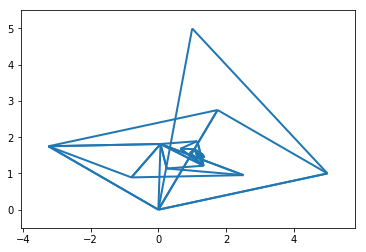

In [8]:
import numpy as np
import pylab as pl
from matplotlib import collections  as mc

lines = []

for i in vs:
    lines.append([i[0], i[1]])
    lines.append([i[0], i[2]])
    lines.append([i[2], i[1]])
    
lc = mc.LineCollection(lines, linewidths=2)
fig, ax = pl.subplots()
ax.add_collection(lc)
ax.autoscale()
ax.margins(0.1)
    
plt.show()

In [9]:
def autocorrection(l, n):
    resp = []
    m = mean(l)
    
    for i in range(n):
        c = 0
        for j in range(len(l) - i):
            c += (l[j] - m) * (l[i + j] - m)
        resp.append(c / (len(l) - i))
    return resp

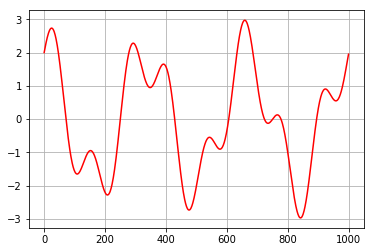

In [10]:
from numpy import array, arange, mean, var, abs as np_abs
from numpy.fft import rfft, rfftfreq
from math import sin, pi, cos, sqrt
import matplotlib.pyplot as plt
import matplotlib as mpl
import random

N = 1000
w = (2 * pi / N)
signal = array([sin(8 * w * t) + 2 * cos(3 * w * t) for t in range(N)])
plt.plot(arange(N), signal, 'r')
plt.grid(True)
plt.show()

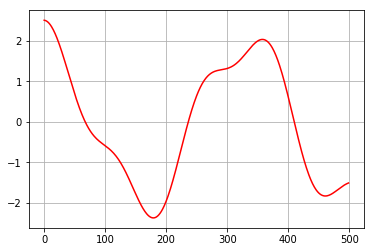

In [11]:
a = autocorrection(signal, 500)

plt.plot(arange(len(a)), a, 'r')
plt.grid(True)
plt.show()

In [12]:
G = [random.gauss(0,1) for i in range(100)]

Метод Рунге-Кутта решения СОДУ

In [44]:
import matplotlib.pyplot as plt
import numpy as np

def RK4(f, y0, ts):
    m = len(y0)
    step = ts[1] - ts[0]
    y = y0
    ysol = [y0[:]]
    
    for t in ts[1:]:
        k1 = f(y, t)
        yp2 = y + k1*(step/2)
        k2 = f(yp2, t+step/2)
        yp3 = y + k2*(step/2)
        k3 = f(yp3, t+step/2)
        yp4 = y + k3*step
        k4 = f(yp4, t+step)

        for j in range(m):
            y[j] += (step/6)*(k1[j] + 2*k2[j] + 2*k3[j] + k4[j])
        
        ysol.append(y[:])

    return ysol

In [45]:
t = [0.1*i for i in range(100)]
x0 = [10, 2]
    
x1 = odeint(get_f(a1=1.29465728,b1=0.5,a2=1.49268351,b2=0.2), x0, t)
x2 = RK4(get_f(a1=1.29465728,b1=0.5,a2=1.49268351,b2=0.2), x0, t)

x1 = [i[1] for i in x1]
x2 = [i[1] for i in x2]


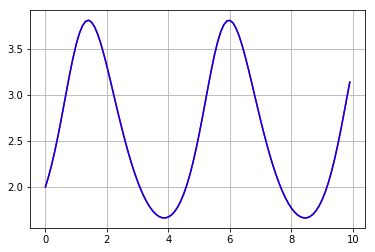

In [48]:
plt.plot(t, x1, 'r')
plt.plot(t, x2, 'b')
plt.grid(True)
plt.show()